In [56]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import pickle as pkl
import hist
import matplotlib.pyplot as plt
from analyzer.run_analysis import runModulesOnSamples
from analyzer.datasets import loadSamplesFromDirectory
import numpy as np
from analyzer.core import modules as all_modules
from analyzer.plotting.core_plots import *
from analyzer.plotting.simple_plot import Plotter
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
loadStyles()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pickle as pkl
file_name="../analyzerout/chargino_reco.pkl"
data = pkl.load(open(file_name, 'rb'))
histos = data["histograms"]

In [38]:
m4 = histos["m14_vs_m24"]["Skim_QCDInclusive2018",...]
new_m4 = m4.copy(deep=True)

In [36]:
new_m4.reset()
v = np.random.multivariate_normal([1000,1500],[[10000,0],[0,36000]],1000)
new_m4.fill(v[:,0],v[:,1],weight=1)
m4=new_m4
#m4 = histos["m14_m"]["Skim_QCDInclusive2018",...]

In [37]:
bound = 1100
m4_real = m4
x,y = [x.centers for x in m4_real.axes]
X,Y = np.meshgrid(x,y)
points = np.stack((X.ravel(),Y.ravel()), axis=1)
print(points)
train_x = torch.from_numpy(points)
train_y = torch.from_numpy(m4_real.values().ravel())
print(train_y)
#train_y = train_y - train_y.mean(dim=-1,keepdim=True)

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2) 
          # gpytorch.kernels.RBFKernel(active_dims=torch.tensor([1,0])) * 
          # gpytorch.kernels.RBFKernel(active_dims=torch.tensor([0,1])) * 
          # gpytorch.kernels.RBFKernel(active_dims=torch.tensor([1,1])) 
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
# initialize likelihood and model
v = torch.from_numpy(m4_real.variances())
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=v, learn_additional_noise=True)
v = torch.sqrt(v) 
model = ExactGPModel(train_x, train_y, likelihood)
print(model)

ValueError: not enough values to unpack (expected 2, got 1)

In [34]:
# this is for running the notebook in our testing framework
model = ExactGPModel(train_x, train_y, likelihood)
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param}')
    
#model.covar_module.base_kernel.lengthscale = 205
model.covar_module.outputscale = 10
model.covar_module.base_kernel.lengthscale=torch.tensor([600,600])
model.train()

likelihood.train()
optimizer = torch.optim.Adam([{"params": model.covar_module.base_kernel.parameters(), "lr": 25},
                              {"params": [model.covar_module.raw_outputscale], "lr": 1e9},
                              {"params": model.mean_module.parameters(), "lr": 500}
                            ]
                           )
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    for param_name, param in model.named_parameters():
        print(f'Parameter name: {param_name:42} value = {param}')
    #print('Iter %d - Loss: %.3f   lengthscale: %.3f  scale: %.3f  mean:%0.3f'  % (
      # i + 1,  loss.item(),
      #  model.covar_module.base_kernel..item(),
     #   model.covar_module.outputscale.item(),
      #  model.mean_module.constant.item()
   # ))
    optimizer.step()

Parameter name: likelihood.second_noise_covar.raw_noise    value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(0., requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(0., requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[0., 0.]], requires_grad=True)
Parameter name: likelihood.second_noise_covar.raw_noise    value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(0., requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(10.0000, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[600., 600.]], requires_grad=True)
Parameter n

Parameter name: likelihood.second_noise_covar.raw_noise    value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(-2432.0317, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(4.8811e+09, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[490.9268, 629.8438]], requires_grad=True)
Parameter name: likelihood.second_noise_covar.raw_noise    value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(-2482.3320, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(4.9826e+09, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[478.00

Parameter name: likelihood.second_noise_covar.raw_noise    value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(-2862.9895, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(5.7558e+09, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[371.0694, 697.4615]], requires_grad=True)
Parameter name: likelihood.second_noise_covar.raw_noise    value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(-2873.9539, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(5.7783e+09, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[362.42

Parameter name: likelihood.second_noise_covar.raw_noise    value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(-2956.7886, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(5.9513e+09, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[297.7601, 697.4152]], requires_grad=True)
Parameter name: likelihood.second_noise_covar.raw_noise    value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(-2959.0518, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(5.9563e+09, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[294.51

Parameter name: likelihood.second_noise_covar.raw_noise    value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(-2974.2949, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(5.9941e+09, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[310.9857, 627.8101]], requires_grad=True)
Parameter name: likelihood.second_noise_covar.raw_noise    value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(-2974.5591, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(5.9952e+09, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[323.41

Parameter name: likelihood.second_noise_covar.raw_noise    value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(-2974.2771, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(6.0031e+09, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[459.9073, 727.4797]], requires_grad=True)
Parameter name: likelihood.second_noise_covar.raw_noise    value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(-2973.9573, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(6.0034e+09, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[466.64

Parameter name: likelihood.second_noise_covar.raw_noise    value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(-2966.3125, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(6.0050e+09, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[512.1254, 768.5926]], requires_grad=True)
Parameter name: likelihood.second_noise_covar.raw_noise    value = Parameter containing:
tensor([0.], requires_grad=True)
Parameter name: mean_module.raw_constant                   value = Parameter containing:
tensor(-2965.7307, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = Parameter containing:
tensor(6.0051e+09, requires_grad=True)
Parameter name: covar_module.base_kernel.raw_lengthscale   value = Parameter containing:
tensor([[505.70

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()
#model.covar_module.base_kernel.lengthscale = 10

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(1000, 3100,1500)
    #test_x = train_x.flatten()
    observed_pred = likelihood(model(test_x),noise=torch.zeros_like(test_x).flatten())
    #observed_pred = model(test_x)
    print(model.mean_module.constant)
    print(observed_pred.mean)
    # Initialize plot
    f, ax = plt.subplots()

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    #ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.errorbar(train_x.numpy(), train_y.numpy(), yerr=v, fmt='o', markersize=3)

    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)

    ax.legend(['Observed Data', 'Mean', 'Confidence'])


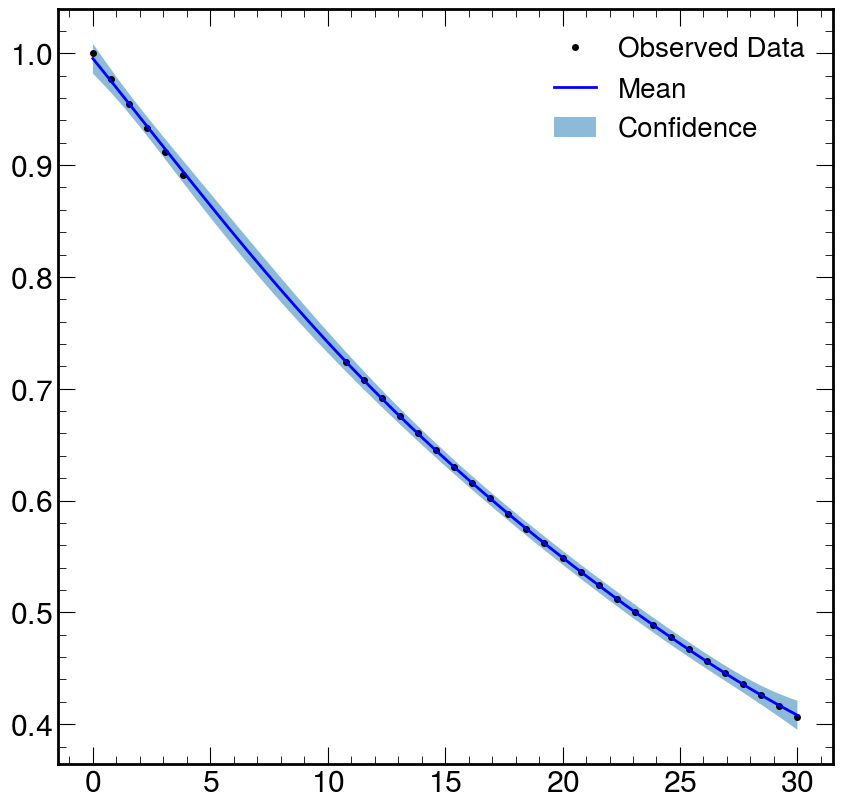

In [93]:
train_x = torch.linspace(0,30,40)
train_x = train_x[(train_x < 4 ) | (train_x > 10)]
#train_y = torch.ones_like(train_x) * 2
train_y = torch.exp(-0.03 * train_x)
#train_y = torch.reshape(train_y)
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() 
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
likelihood.noise =0.01
model.covar_module.base_kernel.lengthscale = 10
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(),lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    for param_name, param in model.named_parameters():
        pass
        #print(f'Parameter name: {param_name:42} value = {param}')
    optimizer.step()

likelihood.eval()
model.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0,30,200)
    observed_pred = likelihood(model(test_x),noise=torch.zeros_like(test_x).flatten()) 
    f, ax = plt.subplots()
    lower, upper = observed_pred.confidence_region()
    ax.plot(train_x.numpy(), train_y.numpy(), "ko", markersize=4,)
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])